In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
from pyproj import Transformer
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df = pd.read_csv('no_long_lat_nulls_2023.csv')
df.head()


,Month,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category
0,2023-01,Avon and Somerset Constabulary,-2.491616,51.424619,On or near Julius Place,E01014399,Bath and North East Somerset 001A,Anti-social behaviour,Not documented
1,2023-01,Avon and Somerset Constabulary,-2.491146,51.425008,On or near Maximus Gardens,E01014399,Bath and North East Somerset 001A,Drugs,Unable to prosecute suspect
2,2023-01,Avon and Somerset Constabulary,-2.491616,51.424619,On or near Julius Place,E01014399,Bath and North East Somerset 001A,Drugs,Unable to prosecute suspect
3,2023-01,Avon and Somerset Constabulary,-2.509285,51.409716,On or near Barnard Walk,E01014399,Bath and North East Somerset 001A,Vehicle crime,Status update unavailable
4,2023-01,Avon and Somerset Constabulary,-2.509285,51.409716,On or near Barnard Walk,E01014399,Bath and North East Somerset 001A,Violence and sexual offences,Offender given a caution


#### Now we will calculate the crime rate using crimes per 1000 people rather than within an area 

In [3]:
lsoa_map = gpd.read_file('./lsoa_shape/infuse_lsoa_lyr_2011.shp')

In [4]:
lsoa_map.head()


,geo_code,geo_label,geo_labelw,label,name,geometry
0,E01003513,Newham 035D,None,E92000001E09000025E01003513,Newham 035D,"POLYGON ((541893.189 181249.621, 541900.568 18..."
1,E01031647,Horsham 002D,None,E92000001E07000227E01031647,Horsham 002D,"POLYGON ((518376.682 132574.695, 518375.785 13..."
2,E01022006,Tendring 002C,None,E92000001E07000076E01022006,Tendring 002C,"POLYGON ((623754.716 231042.037, 623759.750 23..."
3,E01001159,Croydon 002C,None,E92000001E09000008E01001159,Croydon 002C,"POLYGON ((532233.977 170474.976, 532229.824 17..."
4,E01008088,Sheffield 012B,None,E92000001E08000019E01008088,Sheffield 012B,"POLYGON ((433539.233 392096.845, 433539.125 39..."


In [5]:
print(lsoa_map.crs)


EPSG:27700


In [6]:
# Define a transformer to convert from WGS 84 (EPSG:4326 used by google maps) to British National Grid (EPSG:27700)
transformer = Transformer.from_crs("EPSG:4326", "EPSG:27700", always_xy=True)

def find_lsoa(longitude, latitude):
    # Transform the coordinates from longitude, latitude to British National Grid
    new_longitude, new_latitude = transformer.transform(longitude, latitude)
    
    # Create a point from the transformed longitude and latitude
    point = Point(new_longitude, new_latitude)
    
    # Find the LSOA which contains the point
    containing_lsoa = lsoa_map[lsoa_map.geometry.contains(point)]
    
    # Check if any LSOA was found
    if not containing_lsoa.empty:
        return containing_lsoa
    else:
        return "No LSOA found for the given coordinates."

# Example usage
longitude = -2.491616	
latitude = 51.424619
result = find_lsoa(longitude, latitude)
lsoa_code = result.iloc[0]['geo_code']
print("The LSOA code for the entered location is:", lsoa_code)


The LSOA code for the entered location is: E01014399


In [7]:
lsoa_population_df = pd.read_excel('sapelsoabroadagetablefinal.xlsx', sheet_name='Mid-2022 LSOA 2021')



In [8]:
lsoa_population_df.head()

,LAD 2021 Code,LAD 2021 Name,LSOA 2021 Code,LSOA 2021 Name,Total,F0 to 15,F16 to 29,F30 to 44,F45 to 64,F65 and over,M0 to 15,M16 to 29,M30 to 44,M45 to 64,M65 and over
0,E06000001,Hartlepool,E01011949,Hartlepool 009A,1866,185,170,179,266,174,193,175,157,237,130
1,E06000001,Hartlepool,E01011950,Hartlepool 008A,1094,101,80,103,140,96,101,91,135,166,81
2,E06000001,Hartlepool,E01011951,Hartlepool 007A,1240,95,124,144,167,92,125,96,138,189,70
3,E06000001,Hartlepool,E01011952,Hartlepool 002A,1620,192,129,155,208,196,190,110,100,205,135
4,E06000001,Hartlepool,E01011953,Hartlepool 002B,1979,214,219,191,235,139,289,179,160,228,125


In [9]:
lsoa_population_df = lsoa_population_df[['LSOA 2021 Code', 'Total']]
lsoa_population_df.head()

,LSOA 2021 Code,Total
0,E01011949,1866
1,E01011950,1094
2,E01011951,1240
3,E01011952,1620
4,E01011953,1979


In [10]:
# Count crimes per LSOA code
crime_counts = df.groupby('LSOA code').size().reset_index(name='Crime count')

In [11]:
merged_df = pd.merge(lsoa_population_df, crime_counts, left_on='LSOA 2021 Code', right_on='LSOA code', how='left')
merged_df.head()


,LSOA 2021 Code,Total,LSOA code,Crime count
0,E01011949,1866,E01011949,272.0
1,E01011950,1094,E01011950,547.0
2,E01011951,1240,E01011951,565.0
3,E01011952,1620,E01011952,430.0
4,E01011953,1979,E01011953,320.0


In [12]:
merged_df.isnull().sum()


LSOA 2021 Code       0
Total                0
LSOA code         1360
Crime count       1360
dtype: int64

In [13]:
merged_df = merged_df.dropna(subset=['LSOA code'])
merged_df = merged_df.drop(columns=['LSOA 2021 Code'])
merged_df.isnull().sum()


Total          0
LSOA code      0
Crime count    0
dtype: int64

In [14]:
merged_df = merged_df.rename(columns={'Total': 'Total population'})
desired_columns_order = ['LSOA code' ,'Total population', 'Crime count']
merged_df = merged_df[desired_columns_order]
merged_df.head()

,LSOA code,Total population,Crime count
0,E01011949,1866,272.0
1,E01011950,1094,547.0
2,E01011951,1240,565.0
3,E01011952,1620,430.0
4,E01011953,1979,320.0


In [15]:
if (merged_df['Crime count'] == 0).any():
    print("There are places where Crime count is equal to 0.")
else:
    print("Crime count is not equal to 0 anywhere.")

Crime count is not equal to 0 anywhere.


In [16]:
merged_df['Crimes per 1000'] = (merged_df['Crime count'] / merged_df['Total population']) * 1000
merged_df.describe()

,Total population,Crime count,Crimes per 1000
count,34312.000000,34312.000000,34312.000000
mean,1688.888144,166.947394,97.238693
std,375.579357,240.119856,125.375397
min,933.000000,1.000000,0.315060
25%,1443.000000,68.000000,42.065861
50%,1618.000000,116.000000,69.598944
75%,1856.000000,196.000000,115.735262
max,9588.000000,12613.000000,6915.021930


In [17]:
merged_df.head()

,LSOA code,Total population,Crime count,Crimes per 1000
0,E01011949,1866,272.0,145.766345
1,E01011950,1094,547.0,500.000000
2,E01011951,1240,565.0,455.645161
3,E01011952,1620,430.0,265.432099
4,E01011953,1979,320.0,161.697827


In [ ]:
merged_df.to_csv("E:\sherry\gp\\LSOA_code_crime_count.csv", index=False)

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
C:\Users\lenovo\AppData\Local\Temp\ipykernel_23172\393539310.py:1: SyntaxWarning: invalid escape sequence '\s'
  merged_df.to_csv("E:\sherry\gp\\LSOA_code_crime_count.csv", index=False)


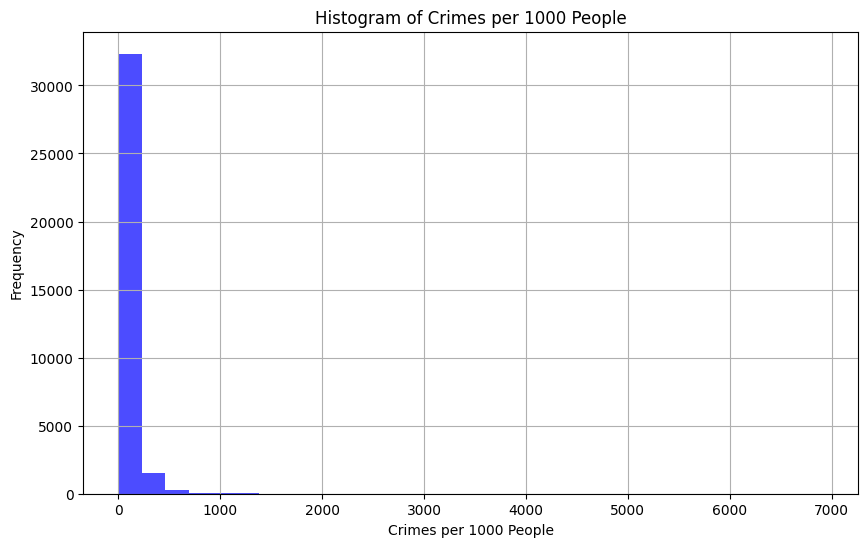

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(merged_df['Crimes per 1000'], bins=30, color='blue', alpha=0.7)
plt.title('Histogram of Crimes per 1000 People')
plt.xlabel('Crimes per 1000 People')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

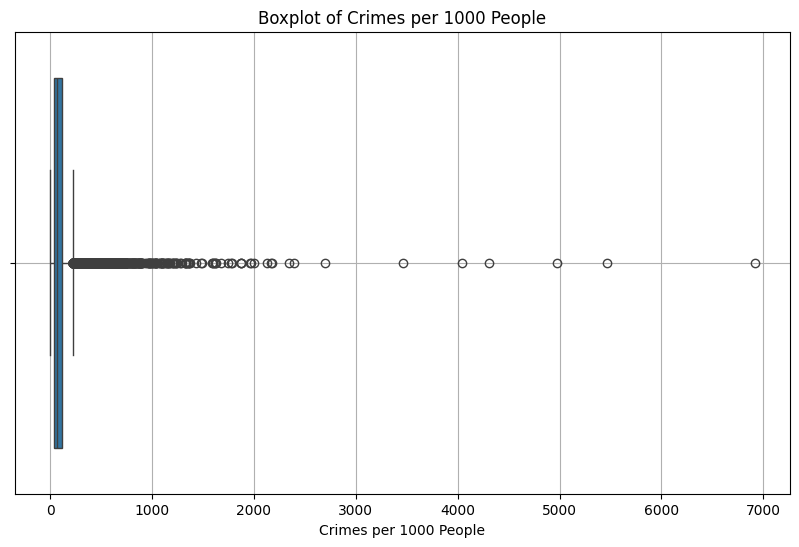

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=merged_df['Crimes per 1000'])
plt.title('Boxplot of Crimes per 1000 People')
plt.xlabel('Crimes per 1000 People')
plt.grid(True)
plt.show()

In [ ]:
merged_df.loc[merged_df['Crime count'].idxmax()]

LSOA code            E01004734
Total population          1824
Crime count            12613.0
Crimes per 1000     6915.02193
Name: 33709, dtype: object

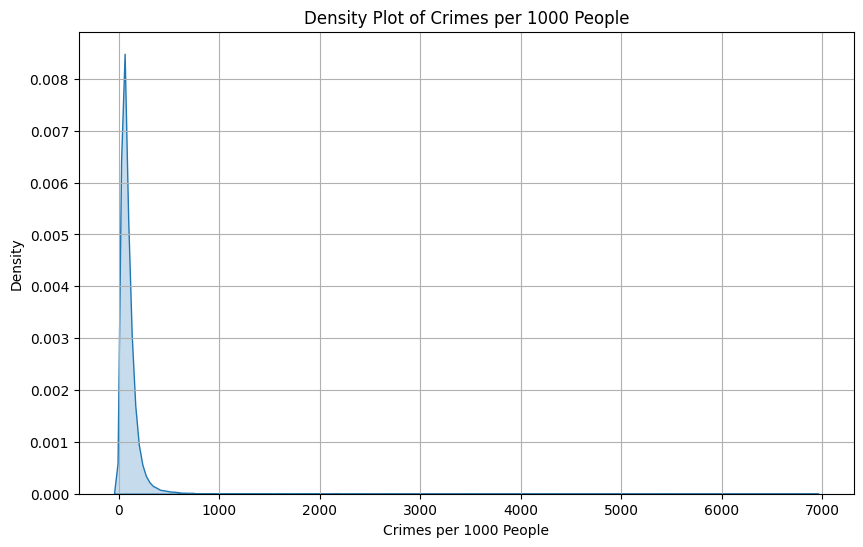

In [ ]:
plt.figure(figsize=(10, 6))
sns.kdeplot(merged_df['Crimes per 1000'], fill=True)
plt.title('Density Plot of Crimes per 1000 People')
plt.xlabel('Crimes per 1000 People')
plt.grid(True)
plt.show()

In [ ]:
quantiles = merged_df['Crimes per 1000'].quantile([0.20, 0.40, 0.60, 0.80]).tolist()

print("Crime Rate Thresholds:")
print(f"Very Low Crime: <= {quantiles[0]}")
print(f"Low Crime: > {quantiles[0]} and <= {quantiles[1]}")
print(f"Moderate Crime: > {quantiles[1]} and <= {quantiles[2]}")
print(f"High Crime: > {quantiles[2]} and <= {quantiles[3]}")
print(f"Very High Crime: > {quantiles[3]}")


Crime Rate Thresholds:
Very Low Crime: <= 37.484700341790536
Low Crime: > 37.484700341790536 and <= 57.38737955096794
Moderate Crime: > 57.38737955096794 and <= 84.57123998114098
High Crime: > 84.57123998114098 and <= 130.50818474077755
Very High Crime: > 130.50818474077755


In [ ]:
#test with north yorkshire lsoa code, supposed to be safe and it says so
merged_df[merged_df['LSOA code'] == 'E01027636']

,LSOA code,Total population,Crime count,Crimes per 1000
16591,E01027636,2035,44.0,21.621622
